##### Import std libraries used in the model

In [1]:
import cv2
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split

## Read in road images, categorized with/out vehicels, and split into training & validation sets

In [2]:
car_imgfiles = sorted(glob('./data/vehicles/' +'*/*.png'))
noncar_imgfiles = sorted(glob('./data/non-vehicles/' +'*/*.png'))
print('Total training images: ', len(car_imgfiles), 'cars,', len(noncar_imgfiles), 'non-cars')
ncars = len(car_imgfiles) # approx. car/noncar division in training set, used for sampling for humans

img_list = []
for f in car_imgfiles:   # car_imgs[:len(car_imgs)//bags*bags]
    img_list.append(cv2.imread(f))
for f in noncar_imgfiles:
    img_list.append(cv2.imread(f))
dataX = np.array(img_list, dtype=np.uint8)
print('input dataX is ', type(dataX), dataX.shape)
print('cars are ', dataX[:ncars].shape, 'non-cars are ', dataX[ncars:].shape)

Total training images:  46 cars, 43 non-cars
input dataX is  <class 'numpy.ndarray'> (89, 64, 64, 3)
cars are  (46, 64, 64, 3) non-cars are  (43, 64, 64, 3)


We shall keep cars & noncars separate, for easy use in sampling for humans, and delaying creating output array. 

Inorder to account for time series nature of input data, 
*  we divide the data into bagSize consecutive frames, 
*  and keep bags, while splitting into training & test sets

In [3]:
bagSize = 20 
data_y = dataX[0:ncars//bagSize*bagSize].reshape(-1,bagSize,*dataX.shape[-3:])
data_n = dataX[ncars:ncars+(len(dataX)-ncars)//bagSize*bagSize].reshape(-1,bagSize,*dataX.shape[-3:])
print('input dataX is ', type(dataX), dataX.shape)
print('of which YES are ', data_y.shape, 'and NO are ', data_n.shape)

# split the bags and reshape to N*height*width*channel
input_train_y, input_test_y = train_test_split(data_y, test_size=0.2)
input_train_n, input_test_n = train_test_split(data_n, test_size=0.2)
#trainX, testX = train_test_split(dataX, test_size=0.2)
#print('training dataX is ', type(trainX), dataX_train.shape)
input_train_y = input_train_y.reshape(-1,*dataX.shape[-3:])
input_test_y = input_test_y.reshape(-1,*dataX.shape[-3:])
input_train_n = input_train_n.reshape(-1,*dataX.shape[-3:])
input_test_n = input_test_n.reshape(-1,*dataX.shape[-3:])
print('training data is ', type(input_train_y), input_train_y.shape, ' cars & noncars ', input_train_n.shape)

input dataX is  <class 'numpy.ndarray'> (89, 64, 64, 3)
of which YES are  (2, 20, 64, 64, 3) and NO are  (2, 20, 64, 64, 3)
training data is  <class 'numpy.ndarray'> (20, 64, 64, 3)  cars & noncars  (20, 64, 64, 3)


Helper function, especially designed to show comparison of samples in jupyter notebook, and also save it.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# a helper function to plot a grid of images from an iterable (list or generator)
def plt_grid_image(img_iterable, grid_shape, img_shape, titles, width=12):
    n_rows, n_cols = grid_shape
    img_height, img_width = img_shape
    
    height = int(1.0*(img_height*n_rows)*width/(n_cols*img_width))
    
    fig = plt.figure(figsize=(width, height), facecolor='white')
    gs = gridspec.GridSpec(n_rows, n_cols, top=0.96, bottom=0.02, right=0.98, left=0.02, hspace=0.001, wspace=0.001)
    
    i = 0
    for imgs in img_iterable:
        j = 0
        for img in imgs:
            ax = plt.subplot(gs[i*n_cols + j])
            ax.imshow(RGB(img))
            ax.axis('off')
            if i==0:
                ax.set_title(titles[j], fontsize=18)

            j += 1
            if j == n_cols:
                break
        i+=1
        if i == n_rows:
            break
    return gs
            
RGB = lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Now let's draw our sample images to sniff the image dataset with/out motorvehicles in them 

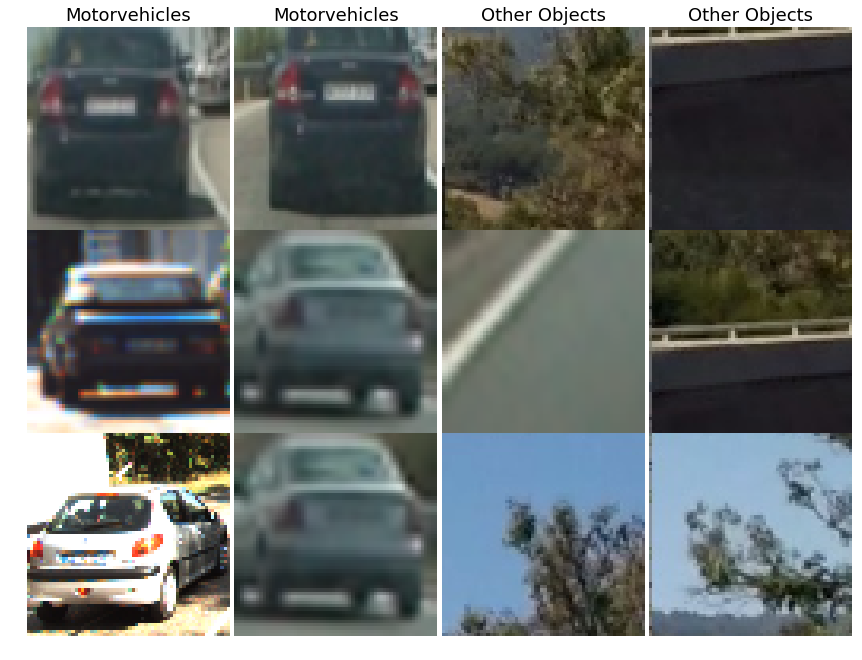

In [5]:
from sklearn.utils import resample

plt_grid_image(zip(resample(input_train_y, n_samples=3), 
                   resample(input_train_y, n_samples=3), 
                   resample(input_train_n, n_samples=3),
                   resample(input_train_n, n_samples=3)), 
               (3,4), input_train_y[0].shape[:2], ['Motorvehicles', 'Motorvehicles', 'Other Objects', 'Other Objects'], 12)
plt.savefig('./output_images/car_noncar.png')

### Feature extraction

# Import Supporting functions from the lesson.  

In [9]:
import skimage.feature

def bin_spatial(img, cspace=None, size=(16, 16)):
    # Convert image to new color space (if specified)
    img = cv2.resize(img, size, cv2.INTER_AREA)
    if cspace is not None:
        img = cv2.cvtColor(img, cspace)
    return img.ravel()

def color_histogram(img,cspace=cv2.COLOR_BGR2HSV, bins=32):
    if cspace is not None:
        img = cv2.cvtColor(img, cspace)
    return np.hstack([np.histogram(np.sqrt(channel).ravel(),bins=bins,normed=True)[0] 
                      for channel in cv2.split(img)])
    
def hog(img, orient=12, pix_per_cell=8, cell_per_block=1, vis=False, feature_vec=True):
    return skimage.feature.hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
               cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
               visualise=vis, feature_vector=feature_vec)

def hogcv(img, orient=12, pix_per_cell=8, cell_per_block=1):
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // pix_per_cell * pix_per_cell,
                                     img.shape[0] // pix_per_cell * pix_per_cell),
                            _blockSize=(cell_per_block * pix_per_cell,
                                       cell_per_block * pix_per_cell),
                            _blockStride=(pix_per_cell, pix_per_cell),
                            _cellSize=(pix_per_cell, pix_per_cell),
                            _nbins=orient)
    return hog.compute(img).ravel()
            
def extract_features(img):
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    return np.hstack([hogcv(luv[:,:,1]), hogcv(luv[:,:,2]), hogcv(luv[:,:,0]), bin_spatial(luv), bin_spatial(img), color_histogram(luv)])

Visualize HOGs for input car/noncar training set. 

channels for car (9, 64, 64) carhog (9, 64, 64)


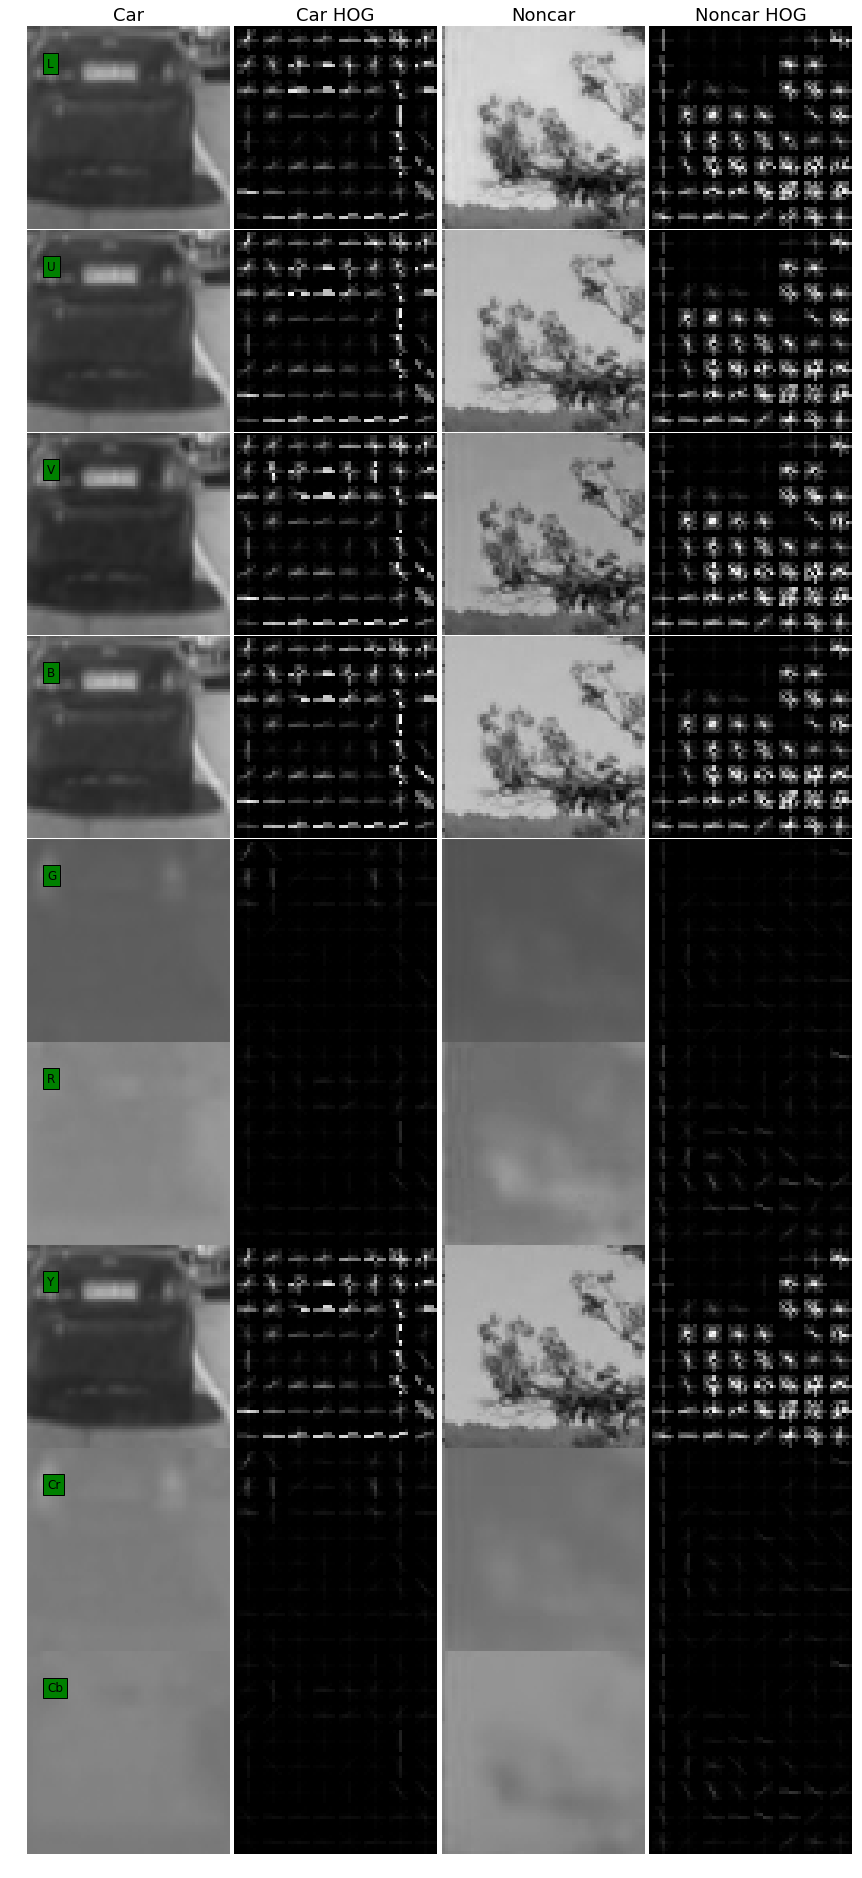

In [23]:
channel_name = ['L', 'U', 'V', 'B', 'G', 'R', 'Y', 'Cr', 'Cb']
carimg = input_train_y[int(np.random.rand()*len(input_train_y))]
noncarimg = input_train_n[int(np.random.rand()*len(input_train_n))]
hogvis = lambda x: gray2bgr((hog(x, vis=True)[1]*255).astype(np.uint8))
gray2bgr = lambda x: cv2.cvtColor(x, cv2.COLOR_GRAY2BGR)

def all_image_channels(img):
    b,g,r = cv2.split(img)
    l,u,v = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2LUV))
    y,cr,cb = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb))
    return np.array([b,g,r,l,u,v,y,cr,cb])

def gray2bgrs(imgs):
    ret = []
    for x in imgs:
        ret.append(cv2.cvtColor(x, cv2.COLOR_GRAY2BGR))
    return np.array(ret)

def hog_vis(imgs, o=12):
    ret = []
    for x in imgs:
        ret.append((hog(x, vis=True, orient=o)[1]*255).astype(np.uint8))
    return np.array(ret)

car = all_image_channels(carimg)
carhog = hog_vis(car)
print('channels for car', car.shape, 'carhog', carhog.shape)

noncar = all_image_channels(noncarimg)
noncarhog = hog_vis(noncar)
show_grid = np.transpose(np.array([gray2bgrs(car), gray2bgrs(carhog), gray2bgrs(noncar), gray2bgrs(noncarhog)]),(1,0,2,3,4))

gs = plt_grid_image(show_grid,
                    (9,4), (64,64), ('Car', 'Car HOG', 'Noncar', 'Noncar HOG'), 12)

for i in range(len(channel_name)):
    ax = plt.subplot(gs[i*4])
    ax.text(0.1, 0.8, channel_name[i], transform=ax.transAxes, bbox=dict(facecolor='green') ,fontsize=12)
plt.savefig('./output_images/HOG.png')

## Train the car/noncar model using linear SVM model 

Extract features from all images in the training set, and normalize the dataset using training scale.    

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV

# Extract features and normalize them using training-scale
from tqdm import tqdm
features_y = [extract_features(img) for img in tqdm(input_train_y)]
features_n = [extract_features(img) for img in tqdm(input_train_n)]

training_features = np.array(features_y + features_n)
training_feature_scale = StandardScaler().fit(training_features)
scaled_training_features = training_feature_scale.transform(training_features)

labels_train = [1]*len(features_y) + [0]*len(features_n)

features_y_test = [extract_features(img) for img in tqdm(input_test_y)]
features_n_test = [extract_features(img) for img in tqdm(input_test_n)]
features_test = np.array(features_y_test + features_n_test)
scaled_features_test = training_feature_scale.transform(features_test)

labels_test = [1]*len(features_y_test) + [0]*len(features_n_test)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 569.92it/s]


# Train the model

Create a process(..) function with transformation pipeline. Given an image, it creates features from spatial binning, color historgram, and Histogram-Of-Gradients, and normalizes them. 

Then create a LinearSVC model and fit it to training features and labels.   

In [ ]:
### def process(img):
    features = pack_features(img)
    scaled_features = training_feature_scale.transform(features)
    pca_features = scaled_features
    return pca_features

class mockPCA:
    def transform(self, x):
        return x
    
pca = mockPCA()
# pca = PCA(n_components=3000)
# pca.fit(scaled_training_features)

svc = LinearSVC(tol=1e-8, C=1e-4)
# svc = SVC(C=1e4, kernel='poly')

pca_training_features = pca.transform(scaled_training_features)
svc.fit(pca_training_features, labels_train)

pca_features_test = pca.transform(scaled_features_test)
pred_labels = svc.predict(pca_features_test)
print('Test Precision of SVC = ', round(precision_score(labels_test, pred_labels), 4))
print('Test Recall of SVC = ', round(recall_score(labels_test, pred_labels), 4))
print('Test Accuracy of SVC = ', round(accuracy_score(labels_test, pred_labels), 4))


### Make Sliding Windows covering the entire image to look for Car objects

Utility functions to draw bounding boxes, or bounding circles if too many on screen, over the image.  

In [ ]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    # Draw bounding rectangles with bbox coordinates
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def draw_spots(img, bboxes, color=(0, 0, 255), thick=1):
    imcopy = np.copy(img)
    for bbox in bboxes:
        # Draw thin multi-color circles within bbox coordinates
        center = ((bbox[0][0]+bbox[1][0])//2, (bbox[0][1]+bbox[1][1])//2)
        cv2.circle(imcopy, center, (bbox[1][0]-bbox[0][0])//2, 
                   (np.random.rand()*color[0],np.random.rand()*color[1],np.random.rand()*color[2]), thick)
    # Return the image copy with boxes drawn
    return imcopy

Slide window over the image and return all permissible bounding boxes. 

In [14]:
def slide_window(img_shape, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    x_start, x_stop = x_start_stop
    y_start, y_stop = x_start_stop
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = min(startx + xy_window[0], img_shape[1]-1)
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = min(starty + xy_window[1], img_shape[0]-1)
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

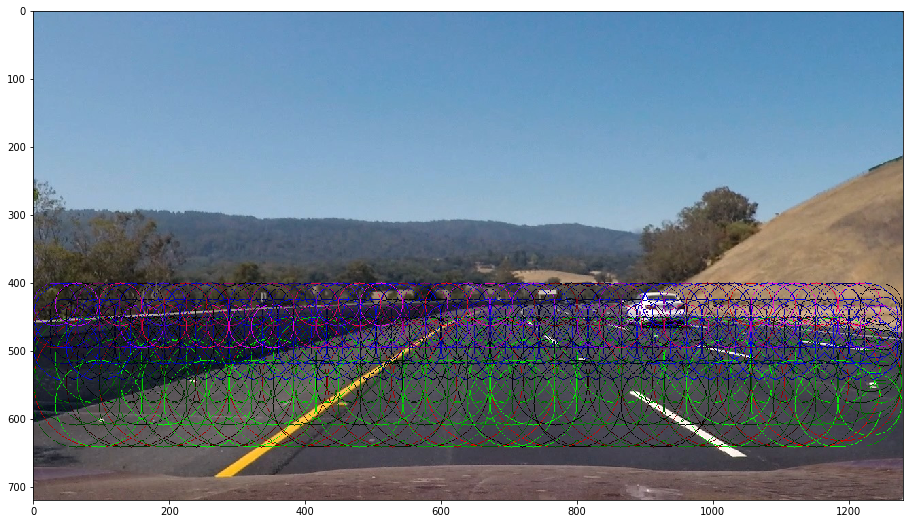

In [15]:
img = cv2.imread('./test_images/test3.jpg')
img_shape = img.shape

windows192 = slide_window(img_shape, y_start_stop=[450, 580], 
                            xy_window=(192, 192), xy_overlap=(0.75, 0.75))
windows128 = slide_window(img_shape, y_start_stop=[450, 600], 
                            xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows96 = slide_window(img_shape, y_start_stop=[400, 500], 
                            xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows64 = slide_window(img_shape, y_start_stop=[400, 500], 
                            xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows = windows64 + windows96 + windows128 + windows192

bboxed_img = img
bboxed_img = draw_spots(bboxed_img, windows192)
bboxed_img = draw_spots(bboxed_img, windows128, (0,255,0))
bboxed_img = draw_spots(bboxed_img, windows96, (255,0,0))
bboxed_img = draw_spots(bboxed_img, windows64, (255,0,255))
plt.figure(figsize=(16,9))
plt.imshow(RGB(bboxed_img))
plt.savefig('./output_images/windows.png')

# Detect car-image containing windows from the given image

Extract features from each of the bounding boxes generated, and pass through the Learning Model to detect vehicles. 

After vehicle detection, add heat on a blank image to create heatmap. 

In [16]:
def extract_features_from_windows(img, windows):
    features = []
    for (x0,y0), (x1,y1) in windows:
        patch = cv2.resize(img[y0:y1,x0:x1], (64,64))
        features.append(extract_features(patch))
    return features

def batch_extract_simple_features_from_windows(img, windows, binsize=(16,16)):
    binh, binw = binsize
    imgh, imgw = img.shape[:2]
    
    windows=np.int_(windows)
    wsize = np.diff(windows,axis=1).squeeze()
    unique_wsize = np.vstack({tuple(row) for row in wsize})
    
    patches = [None]*len(windows)
    
    for winw, winh in unique_wsize:
        rs_img = cv2.resize(img, (binw*imgw//winw+1,binh*imgh//winh+1))            
        idx, = np.where((wsize[:,0]==winh) &  (wsize[:,1]==winw))        
        topleft = windows[idx][:,0,:]*[binw,binh]//[winw,winh]
        for (x, y), i in zip(topleft, range(len(idx))):
            patches[idx[i]] = rs_img[y:y+binh,x:x+binw]
    return np.array(patches).reshape(len(windows),-1)

def detect_veh(img, windows=windows):
    if not windows:
        return []
    features = extract_features_from_windows(img, windows)
    idx, = np.where(svc.predict(pca.transform(training_feature_scale.transform(features)))>0.5)
#     idx, = np.where(svc.predict(training_feature_scale.transform(features))>0.5)
    return [windows[i] for i in idx]

def add_heat(img_shape, windows):
    heatmap = np.zeros(img_shape[:2], dtype=int)
    for (x0,y0), (x1,y1) in windows:
        heatmap[y0:y1, x0:x1] += 1
    return heatmap

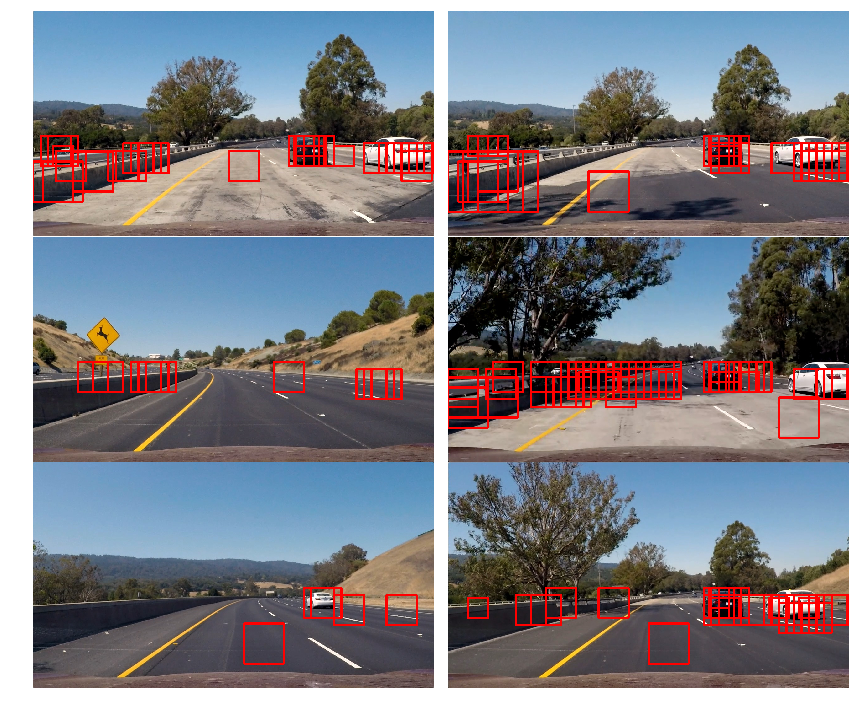

In [17]:
test_imgs = [cv2.imread(img_name) for img_name in sorted(glob('test_images/*.jpg'))]
detected_windows = [detect_veh(img) for img in test_imgs]
bboxed_imgs = [draw_boxes(img, window) for img, window in zip(test_imgs, detected_windows)]
heatmap = [add_heat(test_imgs[0].shape[:2], window) for window in detected_windows]

plt_grid_image(zip(bboxed_imgs[:3], bboxed_imgs[3:]), (3,2), (test_imgs[0].shape[:2]), ['',''])
plt.savefig('./output_images/bboxes.png')

This is the most complex part of model. 

Take the heatmap of identified windows in the image, eliminate false positives by filtering out bbox with heat neighbourhoods. 

In [20]:
import scipy.ndimage.measurements
from queue import Queue

to_cmap_hot = lambda x: cv2.cvtColor((plt.cm.hot(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)/255)[...,:3]*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
to_cmap_accent = lambda x: cv2.cvtColor((plt.cm.Accent(x)[...,:3]*255).astype(np.uint8), cv2.COLOR_RGB2BGR)

class History:
    def __init__(self):
        self.heatmaps = Queue(8)
        self.intheatmaps = Queue(8)
        self.lastintheatmap = None
        self.bboxes = []
        self.count = 0
        self.decay = 0.8
        self.result = None
        self.count = 0
        
    def neighborhood_bboxes(self, windows):
        intersection = []
        for (x0,y0), (x1,y1) in self.bboxes:
            center_x = (x0 + x1)//2
            center_y = (y0 + y1)//2
            for (wx0, wy0), (wx1, wy1) in windows:
                if (abs(wx0 - center_x) <= 128 and abs(wx1 - center_x) <= 128
                    and abs(wy0 - center_y) <= 128 and abs(wy1 - center_y) <= 128):
                    intersection.append(((wx0, wy0), (wx1, wy1)))
        return intersection
        
    def update(self, img):
        search_windows = windows if self.count%5 == 0 else self.neighborhood_bboxes(windows)
        self.count += 1
        new_bboxes = detect_veh(img, search_windows) 
        
        new_heatmap = add_heat(img.shape, new_bboxes)
        self.lastintheatmap = new_heatmap if self.lastintheatmap is None else new_heatmap*0.2 + self.lastintheatmap*0.9

        if(self.heatmaps.full()): self.heatmaps.get()
        self.heatmaps.put(new_heatmap)

        if(self.intheatmaps.full()): self.intheatmaps.get()
        self.intheatmaps.put(self.lastintheatmap)
        
        labels = scipy.ndimage.measurements.label(self.lastintheatmap>2)
        
        heatmap_img = gray2bgr((new_heatmap/(new_heatmap.max()+2)*255).astype(np.uint8))
        intheatmap_img = gray2bgr((self.lastintheatmap/(self.lastintheatmap.max()+2)*255).astype(np.uint8))

        self.bboxes = []
        for veh in range(1, labels[1]+1):
            nonzeroy, nonzerox = (labels[0] == veh).nonzero()
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            if bbox[1][0] - bbox[0][0] > 32 and bbox[1][1]-bbox[0][1] > 32:
                self.bboxes.append(bbox)
                
        bboxed_img = draw_boxes(img, self.bboxes)
        labeled_img = to_cmap_hot(cv2.cvtColor((labels[0]/(labels[0].max()+0.01)*255).astype(np.uint8), cv2.COLOR_GRAY2BGR))
        
        if self.count > 930 and self.count < 960:
            cv2.imwrite('./output_images/img{}.png'.format(self.count), img)
            cv2.imwrite('./output_images/heatmap{}.png'.format(self.count), heatmap_img)
            cv2.imwrite('./output_images/intheatmap{}.png'.format(self.count), intheatmap_img)
            cv2.imwrite('./output_images/bboxed{}.png'.format(self.count), bboxed_img)
            cv2.imwrite('./output_images/labels{}.png'.format(self.count), labeled_img)
            
        intheatmap_img = to_cmap_hot(cv2.resize(intheatmap_img, (intheatmap_img.shape[1]//4, intheatmap_img.shape[0]//4)))
        bboxed_img[:intheatmap_img.shape[0],:intheatmap_img.shape[1]] = intheatmap_img
        return bboxed_img
    

# finally, Run the model pipeline on active video

Also display few working images to see the pipeline.  

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

his = History()

rgb2bgr = lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
input_name = './project_video.mp4'
output_name = './project_video_out.mp4'
clip1 = VideoFileClip(input_name)
white_clip = clip1.fl_image(lambda x: RGB(his.update(rgb2bgr(x)))) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:01<00:00,  2.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

Wall time: 8min 3s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>

""".format(output_name))

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NameError: name 'output_name' is not defined

In [ ]:
to_cmap_hot = lambda x: cv2.cvtColor((plt.cm.hot(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)/255)[...,:3]*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
gs = plt_grid_image([[cv2.imread('./output_images/bboxed{}.png'.format(i)), 
                 to_cmap_hot(cv2.imread('./output_images/heatmap{}.png'.format(i))), 
                 to_cmap_hot(cv2.imread('./output_images/intheatmap{}.png'.format(i))),
                     cv2.imread('./output_images/labels{}.png'.format(i))] for i in range(950, 956)],
               (6,4), img_shape[:2], ('Bounding boxes', 'Heatmap', 'Integrated heatmap', 'Labels'), 12)

plt.savefig('./output_images/heatmap_6frames.png')